In [86]:
import os
import re
import gzip
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from textblob import TextBlob
from tqdm import tqdm_notebook, tqdm
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words 
stop = get_stop_words('english')
%matplotlib inline
tqdm.pandas()
warnings.filterwarnings('ignore')

In [87]:
n_reviews = 1697533
corpus_path = 'reviews_Movies_and_TV_5.json.gz'
corpus_save_path = 'top10.csv'
pos_corpus_save_path = 'pos.csv'
neg_corpus_save_path = 'neg.csv'
pos_one_line_summ_save_path = 'pos_one_line_summ.csv'
neg_one_line_summ_save_path = 'neg_one_line_summ.csv'
pos_merged_save_path = 'pos_merged.csv'
neg_merged_save_path = 'neg_merged.csv'
pos_summ_merged_save_path = 'pos_summ_merged.csv'
neg_summ_merged_save_path = 'neg_summ_merged.csv'
concatenated_summ_save_path = 'concatenated_summ.csv'

In [88]:
def parse(): 
    with gzip.open(corpus_path, 'rb') as g: 
        for l in g: 
            yield eval(l) 

In [89]:
def get_df(): 
    i = 0 
    df = {} 
    for d in tqdm(parse(), total=n_reviews): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index')

In [90]:
def clean_data(df):
    pats = [  
        (re.compile(r'(?:(?<=\.|\s)[A-Z]\.)+'),  r''), 
        (re.compile(r'([a-z])(\W+)([A-Z])'),     r'\1\2 \3'), 
        (re.compile(r'([A-Z])\.\s([A-Z])'),      r'\1.\2'), 
        (re.compile(r'(\w+)\.{2,}\s*(\w+)'),     r'\1 \2'),
        (re.compile(r'(\w+)\.{2,}\s*'),          r'\1.'),  
        (re.compile(r'(\w)\.\((\w)'),            r'\1. (\2'), 
        (re.compile(r'(\w)\)\.(\w)'),            r'\1). \2'), 
        (re.compile(r'(\w)\s+\W+\s+([A-Z])'),    r'\1. \2'), 
        (re.compile(r'([a-z])[,-]+\s+([A-Z])'),  r'\1. \2'), 
        (re.compile(r'&lt?;u>'),                 r''), 
        (re.compile(r'&quot;'),                  r'""') 
    ]
    for p in pats:
        df['reviewText'] = df['reviewText'].progress_apply(lambda x: re.sub(p[0], p[1], x))
    return df

In [91]:
def get_length(sentence):
    tb = TextBlob(sentence)
    punkts = '.?!;'
    return len([sen for sen in tb.sentences if str(sen) not in punkts])

In [92]:
def processed_review(review):
    tb = TextBlob(review)
    punkts = '.?!;'
    return ' '.join(map(str, [sen for sen in tb.sentences if str(sen) not in punkts]))

In [93]:
def preprocess():
    if not os.path.exists(corpus_save_path):
        print('Loading dataset.')
        df = get_df()
        print('Cleaning data.')
        df = clean_data(df)
        print('Filtering reviews with more than 3 sentences.')
        review_lens = df['reviewText'].progress_apply(get_length)
        new_df = df[review_lens > 3]
        top10 = new_df['asin'].value_counts().nlargest(10).keys().tolist()
        top10_reviews = new_df['asin'].apply(lambda x: x in top10)
        new_df = new_df[top10_reviews]
        print('Processing reviews as one space separated sentences.')
        new_df['reviewText'] = new_df['reviewText'].progress_apply(processed_review)
        new_df.to_csv(corpus_save_path, index=False)
    return pd.read_csv(corpus_save_path)

In [94]:
df = preprocess()
movie_ids = df['asin'].unique()

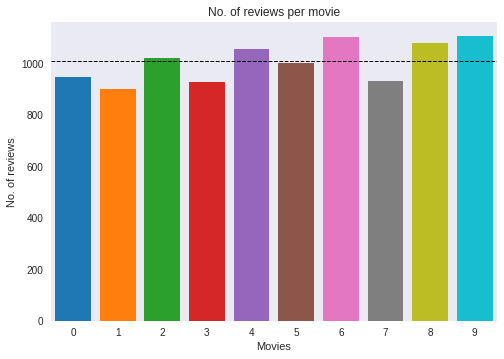

In [95]:
# no of reviews per movie
# sns.set(style='whitegrid')
plt.style.use('seaborn')
n_reviews_per_movie = df.groupby('asin')['asin'].count().tolist()
plt.xlabel('Movies')
plt.ylabel('No. of reviews')
plt.title('No. of reviews per movie')
plt.axhline(np.mean(n_reviews_per_movie), linewidth=1, linestyle='--', color='k')
ax = sns.barplot(x=np.arange(10), y=n_reviews_per_movie, palette='tab10', saturation=1)
ax.grid(False)
plt.savefig('No_of_reviews_per_movie.jpg')

In [96]:
# avg.no of words per movie
ndf = pd.DataFrame()
ndf['asin'] = df['asin']
ndf['avg_words'] = df['reviewText'].progress_apply(lambda x: len(TextBlob(x).words))



  0%|          | 0/10088 [00:00<?, ?it/s]

  0%|          | 14/10088 [00:00<01:14, 136.10it/s]

  0%|          | 32/10088 [00:00<01:08, 146.25it/s]

  1%|          | 53/10088 [00:00<01:03, 156.81it/s]

  1%|          | 78/10088 [00:00<00:57, 174.65it/s]

  1%|          | 94/10088 [00:00<01:03, 156.41it/s]

  1%|          | 111/10088 [00:00<01:03, 158.01it/s]

  1%|▏         | 134/10088 [00:00<00:57, 172.98it/s]

  2%|▏         | 158/10088 [00:00<00:52, 187.95it/s]

  2%|▏         | 178/10088 [00:00<00:53, 183.60it/s]

  2%|▏         | 199/10088 [00:01<00:51, 190.72it/s]

  2%|▏         | 222/10088 [00:01<00:49, 199.11it/s]

  2%|▏         | 243/10088 [00:01<00:51, 192.71it/s]

  3%|▎         | 266/10088 [00:01<00:48, 201.56it/s]

  3%|▎         | 287/10088 [00:01<00:48, 202.77it/s]

  3%|▎         | 308/10088 [00:01<00:54, 180.86it/s]

  3%|▎         | 334/10088 [00:01<00:49, 198.63it/s]

  4%|▎         | 361/10088 [00:01<00:45, 212.57it/s]

  4%|▍         | 384/10088 [00:01<00:47, 2

 28%|██▊       | 2869/10088 [00:15<00:38, 188.06it/s]

 29%|██▊       | 2888/10088 [00:15<00:41, 174.60it/s]

 29%|██▉       | 2913/10088 [00:15<00:37, 191.70it/s]

 29%|██▉       | 2934/10088 [00:15<00:38, 184.07it/s]

 29%|██▉       | 2964/10088 [00:15<00:34, 207.60it/s]

 30%|██▉       | 2988/10088 [00:16<00:32, 215.57it/s]

 30%|██▉       | 3014/10088 [00:16<00:31, 224.15it/s]

 30%|███       | 3040/10088 [00:16<00:30, 233.18it/s]

 30%|███       | 3070/10088 [00:16<00:28, 242.36it/s]

 31%|███       | 3100/10088 [00:16<00:27, 255.47it/s]

 31%|███       | 3133/10088 [00:16<00:25, 268.57it/s]

 31%|███▏      | 3163/10088 [00:16<00:25, 274.20it/s]

 32%|███▏      | 3199/10088 [00:16<00:23, 294.73it/s]

 32%|███▏      | 3230/10088 [00:16<00:24, 275.20it/s]

 32%|███▏      | 3259/10088 [00:17<00:26, 262.11it/s]

 33%|███▎      | 3288/10088 [00:17<00:25, 269.42it/s]

 33%|███▎      | 3319/10088 [00:17<00:24, 279.33it/s]

 33%|███▎      | 3348/10088 [00:17<00:24, 271.88it/s]

 33%|███▎ 

 68%|██████▊   | 6875/10088 [00:30<00:11, 290.65it/s]

 68%|██████▊   | 6907/10088 [00:30<00:11, 279.41it/s]

 69%|██████▉   | 6937/10088 [00:31<00:11, 282.90it/s]

 69%|██████▉   | 6967/10088 [00:31<00:11, 280.82it/s]

 69%|██████▉   | 6998/10088 [00:31<00:10, 288.97it/s]

 70%|██████▉   | 7029/10088 [00:31<00:10, 284.69it/s]

 70%|██████▉   | 7058/10088 [00:31<00:11, 263.60it/s]

 70%|███████   | 7096/10088 [00:31<00:10, 289.59it/s]

 71%|███████   | 7137/10088 [00:31<00:09, 317.33it/s]

 71%|███████   | 7171/10088 [00:31<00:10, 286.24it/s]

 71%|███████▏  | 7202/10088 [00:31<00:10, 285.39it/s]

 72%|███████▏  | 7232/10088 [00:32<00:09, 287.98it/s]

 72%|███████▏  | 7262/10088 [00:32<00:11, 247.21it/s]

 72%|███████▏  | 7296/10088 [00:32<00:10, 268.22it/s]

 73%|███████▎  | 7325/10088 [00:32<00:10, 254.99it/s]

 73%|███████▎  | 7352/10088 [00:32<00:11, 243.73it/s]

 73%|███████▎  | 7378/10088 [00:32<00:11, 240.55it/s]

 73%|███████▎  | 7412/10088 [00:32<00:10, 262.62it/s]

 74%|█████

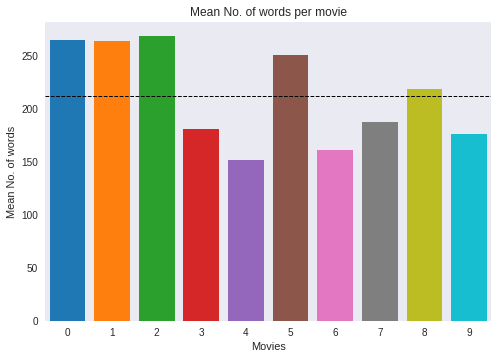

In [97]:
avg_words_per_movie = ndf.groupby('asin')['avg_words'].mean().tolist()
plt.xlabel('Movies')
plt.ylabel('Mean No. of words')
plt.title('Mean No. of words per movie')
plt.axhline(np.mean(avg_words_per_movie), linewidth=1, linestyle='--', color='k')
ax = sns.barplot(x=np.arange(10), y=avg_words_per_movie, palette='tab10', saturation=1)
ax.grid(False)
plt.savefig('Mean_No_of_words_per_movie.jpg')

In [98]:
ndf['avg_sentences'] = df['reviewText'].progress_apply(lambda x: len(TextBlob(x).sentences))



  0%|          | 0/10088 [00:00<?, ?it/s]

  1%|          | 87/10088 [00:00<00:11, 867.38it/s]

  2%|▏         | 166/10088 [00:00<00:11, 841.95it/s]

  3%|▎         | 264/10088 [00:00<00:11, 878.04it/s]

  4%|▎         | 361/10088 [00:00<00:10, 903.43it/s]

  4%|▍         | 446/10088 [00:00<00:10, 885.96it/s]

  5%|▌         | 526/10088 [00:00<00:11, 854.41it/s]

  6%|▌         | 614/10088 [00:00<00:11, 861.26it/s]

  7%|▋         | 694/10088 [00:00<00:11, 828.50it/s]

  8%|▊         | 795/10088 [00:00<00:10, 875.33it/s]

  9%|▊         | 881/10088 [00:01<00:11, 827.73it/s]

 10%|▉         | 963/10088 [00:01<00:11, 769.08it/s]

 10%|█         | 1048/10088 [00:01<00:11, 791.05it/s]

 11%|█         | 1128/10088 [00:01<00:11, 747.39it/s]

 12%|█▏        | 1218/10088 [00:01<00:11, 787.01it/s]

 13%|█▎        | 1302/10088 [00:01<00:10, 799.91it/s]

 14%|█▎        | 1383/10088 [00:01<00:11, 775.72it/s]

 14%|█▍        | 1462/10088 [00:01<00:11, 722.01it/s]

 15%|█▌        | 1541/10088 [00:

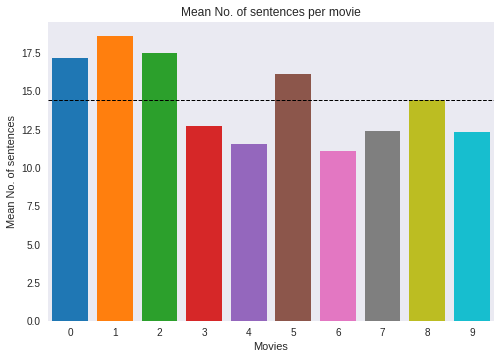

In [100]:
avg_sentences_per_movie = ndf.groupby('asin')['avg_sentences'].mean().tolist()
plt.xlabel('Movies')
plt.ylabel('Mean No. of sentences')
plt.title('Mean No. of sentences per movie')
plt.axhline(np.mean(avg_sentences_per_movie), linewidth=1, linestyle='--', color='k')
ax = sns.barplot(x=np.arange(10), y=avg_sentences_per_movie, palette='tab10', saturation=1)
ax.grid(False)
plt.savefig('Mean_No_of_sentences_per_movie.jpg')

In [101]:
sent_counts = ndf['avg_sentences'].tolist()

In [102]:
word_counts = ndf['avg_words'].tolist()

In [107]:
count_df = pd.DataFrame(index=np.arange(10))
count_df['asin'] = movie_ids
count_df['count'] = df.groupby('asin')['asin'].count().tolist()
count_df.to_html('No_of_reviews_per_movie.html')

In [108]:
count_df = pd.DataFrame(index=np.arange(10))
count_df['asin'] = movie_ids
count_df['avg_words'] = ndf.groupby('asin')['avg_words'].mean().tolist()
count_df.to_html('Mean_No_of_words_per_movie.html')

In [109]:
count_df = pd.DataFrame(index=np.arange(10))
count_df['asin'] = movie_ids
count_df['avg_sents'] = ndf.groupby('asin')['avg_sentences'].mean().tolist()
count_df.to_html('Mean_No_of_sentences_per_movie.html')

In [ ]:
plt.title('No. of sentences for each review')
ax = sns.distplot(sent_counts, bins=25, kde=False, rug=False, norm_hist=False, color='b')
ax.grid(False)
plt.savefig('No_of_sentences_for_each_review.jpg')

In [ ]:
plt.title('No. of words for each review')
ax = sns.distplot(word_counts, bins=25, kde=False, rug=False, norm_hist=False, color='b')
ax.grid(False)
plt.savefig('No_of_words_for_each_review.jpg')

In [ ]:
plt.title('Ratings for each movie')
ax = sns.countplot(x='overall', hue='asin', data=df, palette='tab10', saturation=1)
ax.legend_.remove()
ax.grid(False)
plt.xlabel('ratings')
plt.savefig('Ratings_for_each_movie.jpg')

In [ ]:
plt.title('Distribution of ratings')
ax = sns.countplot(x='overall', data=df, palette='tab10', saturation=1)
ax.grid(False)
plt.savefig('Distribution_of_ratings.jpg')

In [11]:
def get_sentiment(txt):
    tb = TextBlob(txt)
    sentiment = tb.sentiment.polarity
    return sentiment

In [12]:
def sentiment_analysis(df):
    pos_exists = os.path.exists(pos_corpus_save_path)
    neg_exists = os.path.exists(neg_corpus_save_path)
    if not pos_exists or not neg_exists:
        print('Performing Sentiment Analysis.')
        sentiments = df['reviewText'].progress_apply(get_sentiment)
        if not os.path.exists(pos_corpus_save_path):
            pos = df[sentiments > 0]
            pos.to_csv(pos_corpus_save_path, index=False)
            print('Filtered positive reviews.')
        if not os.path.exists(neg_corpus_save_path):
            neg = df[sentiments < 0]
            neg.to_csv(neg_corpus_save_path, index=False)
            print('Filtered negative reviews.')
    pos = pd.read_csv(pos_corpus_save_path)
    neg = pd.read_csv(neg_corpus_save_path)
    return pos, neg

In [13]:
pos, neg = sentiment_analysis(df)

In [ ]:
posneg_df = pd.DataFrame(columns=['asin', 'class'])
posneg_df['asin'] = df['asin']
def get_sentiment_class(x):
    if get_sentiment(x) > 0:
        return 'pos'
    elif get_sentiment(x) == 0:
        return 'neutral'
    else:
        return 'neg'
posneg_df['class'] = df['reviewText'].progress_apply(get_sentiment_class)

 21%|██▏       | 2155/10088 [00:20<00:17, 459.40it/s]

In [ ]:
plt.title('Distribution of reviews based on sentiment')
ax = sns.countplot(x='class', data=posneg_df, palette='tab10', saturation=1)
# ax.legend_.remove()
ax.grid(False)
plt.savefig('Distribution_of_reviews_based_on_sentiment.jpg')

In [ ]:
plt.title('Distribution of reviews based on sentiment per movie')
ax = sns.countplot(x='class', hue='asin', data=posneg_df, palette='tab10', saturation=1)
ax.legend_.remove()
ax.grid(False)
plt.savefig('Distribution_of_reviews_based_on_sentiment_per_movie.jpg')

In [ ]:
scores = df['reviewText'].progress_apply(get_sentiment)

In [ ]:
plt.title('Distribution of sentiment polarities over all reviews')
ax = sns.distplot(scores, bins=75, kde=False, rug=False, norm_hist=False, color='b')
ax.grid(False)
plt.savefig('Distribution_of_sentiment_polarities_over_all_reviews.jpg')

In [15]:
summarizers = [('lsa', LsaSummarizer()), 
               ('textrank', TextRankSummarizer()), 
               ('lexrank', LexRankSummarizer()), 
               ('sumbasic', SumBasicSummarizer())]
summarizers_map = dict(summarizers)

In [16]:
drop_columns = ['reviewerID', 'reviewerName', 'helpful', 'overall', 
                'summary', 'unixReviewTime', 'reviewTime']

In [18]:
movie_ids

array(['0793906091', '630575067X', 'B00003CWT6', 'B0000AQS0F',
       'B001KVZ6HK', 'B002VPE1AW', 'B003EYVXV4', 'B0059XTU1S',
       'B005LAIHXQ', 'B009934S5M'], dtype=object)

In [19]:
lang = 'english'
tokenizer = Tokenizer(lang)
stemmer = Stemmer(lang)
stop_words = get_stop_words(lang)
def oneway_summarize(txt, summarizer, sent_count=20, rec_limit=4):
    summarizer.stop_words = stop_words
    parser = PlaintextParser(txt, tokenizer)
    summary = txt
    if len(TextBlob(summary).sentences) <= sent_count:
        return summary
    try:
        summary = ' '.join(list(map(str, summarizer(parser.document, sent_count))))
        if not summary:
            return txt
    except:
        pass
    if rec_limit and len(TextBlob(summary).sentences) < sent_count:
        return oneway_summarize(txt, summarizer, sent_count + 1, rec_limit - 1)
    return summary

In [20]:
def hierarchical_summarize(txt, summarizer, sent_threshold=1):
    summarizer.stop_words = stop_words
    summary = txt
    prev = summary
    try:
        summ_length = len(TextBlob(summary).sentences) // 2
    except:
        return summary
    try:
        while summ_length >= sent_threshold:
            parser = PlaintextParser(summ, tokenizer)
            prev = summary
            summ = ' '.join(list(map(str, summarizer(parser.document, summ_length))))
            summ_length = len(TextBlob(summary).sentences)
            if not summary or summ_length < sent_threshold:
                return prev
            summ_length //= 2
    except:
        pass
    if len(TextBlob(summary).sentences) < sent_threshold:
        summary = prev
    return oneway_summarize(summary, summarizer, sent_count=sent_threshold)

In [21]:
def create_one_line_summary(df, save_path, fname='', tim=False):
    if not os.path.exists(save_path):
        df_summ = df.drop(drop_columns, axis=1)
        if tim:
            times = []
        for name, summ in summarizers:
            if tim:
                start = time.clock()
            df_summ[name] = df_summ['reviewText'].progress_apply(lambda x: hierarchical_summarize(x, summ))
            if tim:
                times.append((time.clock() - start))
        df_summ.to_csv(save_path, index=False)
        if tim:
            plt.title('Hierarchical Summarization of each {0} review to one sentence'.format(fname))
            plt.xlabel('algorithms')
            plt.ylabel('time')
            ax = sns.barplot(x=[name for name, _ in summarizers], y=times, palette='tab10', saturation=1)
            ax.grid(False)
            plt.savefig('Hierarchical_Summarization_of_each_{0}_review_to_one_sentence.jpg'.format(fname))
    return pd.read_csv(save_path)

In [22]:
pos_one_summ = create_one_line_summary(pos, pos_one_line_summ_save_path, fname='positive', tim=True)

In [23]:
neg_one_summ = create_one_line_summary(neg, neg_one_line_summ_save_path, fname='negative', tim=True)

In [24]:
merged_cols = ['asin', 'lsa', 'textrank', 'lexrank', 'sumbasic' ]
def merge_reviews_per_movie(df, save_path, alpha=1, pol_threshold=0.3):
    if not os.path.exists(save_path):
        merged = pd.DataFrame(index=np.arange(len(movie_ids)), 
                              columns=merged_cols)
        merged['asin'] = movie_ids
        for m, m_id in tqdm(enumerate(movie_ids)):
            for summ, _ in summarizers:
                merged[summ][m] = ' '.join(df[(df['asin'] == m_id) & 
                                              (df[summ].apply(lambda x: alpha * get_sentiment(x) >= pol_threshold))][summ].tolist())
        merged.to_csv(save_path, index=False)
    return pd.read_csv(save_path)

In [25]:
pos_merged = merge_reviews_per_movie(pos_one_summ, 
                                     pos_merged_save_path, 
                                     alpha=1, 
                                     pol_threshold=0.5)

In [26]:
neg_merged = merge_reviews_per_movie(neg_one_summ, 
                                     neg_merged_save_path, 
                                     alpha=-1, 
                                     pol_threshold=0.1)

In [ ]:
pos_merged_sent_df = pd.DataFrame(columns=['asin', 'lsa', 'textrank', 'lexrank', 'sumbasic'])
neg_merged_sent_df = pd.DataFrame(columns=['asin', 'lsa', 'textrank', 'lexrank', 'sumbasic'])
pos_merged_sent_df['asin'] = pos_merged['asin']
neg_merged_sent_df['asin'] = neg_merged['asin']
for summ, _ in summarizers:
    pos_merged_sent_df[summ] = pos_merged[summ].progress_apply(get_sentiment)
    neg_merged_sent_df[summ] = neg_merged[summ].progress_apply(get_sentiment)

In [ ]:
x = [1, 2, 3, 4]
plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Sentiment polarities of positive summaries across different \nalgorithms after Hierarchical Summarization')
for i, j in enumerate(summarizers):
    plt.subplot(2, 2, x[i])
    ax = sns.distplot(pos_merged_sent_df[j[0]], kde=False, rug=False, norm_hist=False, color='b')
    ax.grid(False)
plt.savefig('Sentiment_polarities_of_postive_summaries_across_different_algorithms_after_Hierarchical_Summarization.jpg')

In [ ]:
x = [1, 2, 3, 4]
plt.figure(figsize=(6, 6))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Sentiment polarities of negative summaries across different \nalgorithms after Hierarchical Summarization')
for i, j in enumerate(summarizers):
    plt.subplot(2, 2, x[i])
    ax = sns.distplot(neg_merged_sent_df[j[0]], kde=False, rug=False, norm_hist=False, color='b')
    ax.grid(False)
plt.savefig('Sentiment_polarities_of_negative_summaries_across_different_algorithms_after_Hierarchical_Summarization.jpg')

In [27]:
def summarize_merged_reviews(df, save_path, sent_count=20):
    if not os.path.exists(save_path):
        df_summ = pd.DataFrame(index=np.arange(len(movie_ids)), 
                               columns=merged_cols)
        df_summ['asin'] = movie_ids
        for summ, summarizer in summarizers:
            df_summ[summ] = df[summ].progress_apply(lambda x: hierarchical_summarize(x, summarizer, sent_threshold=sent_count))
        df_summ.to_csv(save_path, index=False)
    return pd.read_csv(save_path)

In [28]:
pos_summ = summarize_merged_reviews(pos_merged, 
                                    pos_summ_merged_save_path, 
                                    sent_count=20)

In [29]:
neg_summ = summarize_merged_reviews(neg_merged, 
                                    neg_summ_merged_save_path, 
                                    sent_count=10)

In [30]:
for summ, _ in summarizers:
    print([len(TextBlob(neg_merged[summ][i]).sentences) for i in range(10)])

[28, 43, 23, 12, 26, 30, 55, 41, 82, 18]
[19, 35, 19, 10, 19, 26, 36, 25, 88, 19]
[16, 40, 19, 11, 22, 23, 32, 18, 81, 20]
[20, 34, 12, 12, 18, 16, 40, 27, 72, 17]


In [31]:
def concatenated_summary(pos_df, neg_df, save_path):
    if not os.path.exists(save_path):
        con_df = pd.DataFrame(index=np.arange(len(movie_ids)), 
                              columns=['asin', 'pos', 'neg'])
        con_df['asin'] = movie_ids
        for m, m_id in enumerate(movie_ids):
            for col_name, col, sent_count in zip(['pos', 'neg'], 
                                     [pos_df, neg_df], 
                                     [20, 10]):
                con_df[col_name][m] = ' '.join([' '.join(map(str, 
                                                [TextBlob(col[summ][m]).sentences[i] 
                                                for summ, _ in summarizers])) 
                                                for i in range(sent_count)])
        con_df.to_csv(save_path, index=False)
    return pd.read_csv(save_path)

In [32]:
concat_summ = concatenated_summary(pos_summ, neg_summ, concatenated_summ_save_path)

In [33]:
sorted(list(set([(sent, sent.polarity) 
        for sent in TextBlob(concat_summ['neg'][9]).sentences])), 
        key=lambda x: x[1])[:10]

[(Sentence("This is  CRAP!"), -1.0),
 (Sentence("Otherwise it would have gotten 5 stars from me, but  I am reducing it to 4 for the annoying shots!!"),
  -1.0),
 (Sentence("This movie didn't disappoint except in one area and it's a pet peeve of mine why does so much evil and bad guyness in the  Star  Trek franchise have to originate in  Star  Fleet  Headquarters?"),
  -0.8499999999999999),
 (Sentence("I don't know if that was a production or streaming problem, but it was annoying."),
  -0.8),
 (Sentence("The movie was a dismal disappointment!"), -0.75),
 (Sentence("What a disappointment!"), -0.75),
 (Sentence("Seriously using roku is terrible."), -0.6666666666666666),
 (Sentence("This character is stupid, disregard's orders, is a drunk, over sexed, coward who creates the problem rather than solving it."),
  -0.6499999999999999),
 (Sentence("...cut them up and sew them together haphazardly, you'd have this movie."),
  -0.6),
 (Sentence("I would have given the movie a 4 star rating if it

In [34]:
pos_features = np.zeros(shape=(len(movie_ids), 80, 7))
neg_features = np.zeros(shape=(len(movie_ids), 40, 7))

In [39]:
def norm_len(x, a, b):
    return - (4 / ((a - b) ** 2)) * (x - a) * (x - b)

In [40]:
for pos_id, posi in enumerate(concat_summ['pos']):
    for sent_id, sent in enumerate(TextBlob(posi).sentences):
        # Feature #1 == No. of Words in each sentence
        pos_features[pos_id, sent_id, 0] = len(sent.words)

        # Feature #2 == Relative Positional score
        block_id = sent_id // 4
        if sent_id < 40:
            pos_features[pos_id, sent_id, 1] = (10 - block_id) / 10
        else:
            pos_features[pos_id, sent_id, 1] = (block_id - 9) / 10

        # Feature #3 ==   numeric data
        pos_features[pos_id, sent_id, 2] = sum([1 for w in sent.words if str(w).isdigit()]) / len(sent.words)

        # Feature #4 ==   alphanumeric data
        pos_features[pos_id, sent_id, 3] = sum([1 for w in sent.words if str(w).isalnum()]) / len(sent.words)

        # Feature #5 == quoted text
        pos_features[pos_id, sent_id, 4] = (sent.find('"') > 0)

        # Feature #6 ==   uppercase data
        pos_features[pos_id, sent_id, 5] = sum([1 for w in sent.words if str(w).isupper()]) / len(sent.words)

        # Feature #7 == sentiment_polarities
        pos_features[pos_id, sent_id, 6] = sent.polarity
    a, b = min(pos_features[pos_id, :, 0]), max(pos_features[0, :, 0])
    for sent_id, sent in enumerate(TextBlob(posi).sentences):
        pos_features[pos_id, sent_id, 0] = norm_len(len(sent.words), a, b)

In [41]:
for neg_id, negi in enumerate(concat_summ['neg']):
    for sent_id, sent in enumerate(TextBlob(negi).sentences):
        # Feature #1 == No. of Words in each sentence
        neg_features[neg_id, sent_id, 0] = len(sent.words)

        # Feature #2 == Relative Positional score
        block_id = sent_id // 2
        if sent_id < 20:
            neg_features[neg_id, sent_id, 1] = (10 - block_id) / 10
        else:
            neg_features[neg_id, sent_id, 1] = (block_id - 9) / 10

        # Feature #3 ==   numeric data
        neg_features[neg_id, sent_id, 2] = sum([1 for w in sent.words if str(w).isdigit()]) / len(sent.words)

        # Feature #4 ==   alphanumeric data
        neg_features[neg_id, sent_id, 3] = sum([1 for w in sent.words if str(w).isalnum()]) / len(sent.words)

        # Feature #5 == quoted text
        neg_features[neg_id, sent_id, 4] = (sent.find('"') > 0)

        # Feature #6 ==   uppercase data
        neg_features[neg_id, sent_id, 5] = sum([1 for w in sent.words if str(w).isupper()]) / len(sent.words)

        # Feature #7 == sentiment_polarities
        neg_features[neg_id, sent_id, 6] = -sent.polarity
    a, b = min(neg_features[neg_id, :, 0]), max(neg_features[0, :, 0])
    for sent_id, sent in enumerate(TextBlob(negi).sentences):
        neg_features[neg_id, sent_id, 0] = norm_len(len(sent.words), a, b)

In [42]:
pos_features[0][0]

array([ 0.98097503,  1.        ,  0.        ,  0.96969697,  0.        ,
        0.09090909,  0.55      ])

In [43]:
pos_scores = pos_features.mean(axis=2)
neg_scores = neg_features.mean(axis=2)

In [44]:
gold_pos_idx = pos_scores.argsort()[:, -20:][:, ::-1]
gold_neg_idx = neg_scores.argsort()[:, -10:][:, ::-1]

In [45]:
gold_pos = []
for pos_id, posi in enumerate(concat_summ['pos']):
    all_sents = TextBlob(posi).sentences
    gold_sents = [all_sents[i] for i in gold_pos_idx[pos_id]]
    gold_review = ' '.join(map(str, gold_sents))
    gold_pos.append(gold_review)

In [46]:
gold_neg = []
for neg_id, negi in enumerate(concat_summ['neg']):
    all_sents = TextBlob(negi).sentences
    gold_sents = [all_sents[i] for i in gold_neg_idx[neg_id]]
    gold_review = ' '.join(map(str, gold_sents))
    gold_neg.append(gold_review)

In [47]:
gold_pos

['If someone asks if  I like  Star  Wars, what  I do is say, "" Those are good movies, but have you seen  The  Matrix?!?!"" Star  Wars" trilogy is in my opinion the greatest trilogy that has ever been made. Empire of  Dreams" is fascinating, a inpsiring work about filmmaking, special effects, creativity and the way a vision can change between the treatment and the images\' arrival on celluloid. Star  Wars" is, to this day, one of the greatest sci-fi films of all time! The  Good vs. Lord of the  Rings", they grossed millions of dollars at the box-office, excellent acting, inspiring special effects and good plotlines help this movie, nothing can\'t beat the holy trilogy of movies. dum dum dum do dee dum do dee dum(darth vader theme)one of the best film series ever made. I used to be a fan of  George  Lucas - that is until he started messing around with computer graphics and forgot just what it was that made his films so charming - the people. I have to say, though the  DVD Widescreen ver

In [64]:
if not os.path.exists('summaries'):
    os.makedirs('summaries')
    os.makedirs('summaries/pos')
    os.makedirs('summaries/neg')

In [65]:
for x, y, z in zip(['pos', 'neg'], 
                   [gold_pos, gold_neg], 
                   [pos_summ, neg_summ]):    
    for i, name in enumerate(movie_ids):
        folder = 'summaries/{0}/{1}'.format(x, name)
        if not os.path.exists(folder):
            os.makedirs(folder)
        with open(os.path.join(folder, 'gold.txt'), 'w') as f:
            for l in TextBlob(y[i]).sentences:
                f.write(str(l) + '\n')
        for j, summ in enumerate(summarizers):
            with open(os.path.join(folder, summ[0] + '.txt'), 'w') as g:
                for l in TextBlob(z[summ[0]][i]).sentences:
                    g.write(str(l) + '\n')